In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import gaussian_kde,uniform, expon
import preprocessing
import pandas as pd
from cmdstanpy import CmdStanModel
from scipy.special import expit, logit
import nest_asyncio
import seaborn as sns

from matplotlib.lines import Line2D

/Users/shuheihara/opt/anaconda3/envs/stan/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
def circular_inference(prior, left_like,right_like,param):

    pa1 = param[0]/2 +0.5
    pa2 = param[1]/2 +0.5
    pa3 = param[2]
    pa4 = param[3]

    #prior logit
    Cp = prior
    Fp = 1 - prior
    Lp = np.log(Cp/Fp)
    aplp = pa3*Lp
    Faplpwp = l_w(aplp,pa1)

    #likelihood logit
    Li_le = left_like
    Li_ri = right_like
    Ls = np.log(Li_le/Li_ri) 
    asls = pa4*Ls
    Faslsws = l_w(asls,pa2)

    Lc = l_w(Ls+Faplpwp+Faslsws,pa2) + l_w(Lp+Faslsws+Faplpwp,pa1)
    pred_c = np.exp(Lc)/(1+np.exp(Lc)) #+ np.random.uniform(low=-0.1, high=0.1)

    pred_c = np.clip(pred_c,0.018,0.982)
    

    return pred_c

In [5]:
def l_w(L,w):
    f = np.log((w*np.exp(L)+1-w) / ((1-w)*np.exp(L)+w))
    return f

In [4]:
data, image_data = preprocessing.preprocess()

# Change the likelihood value 
likelihood_dir='/Users/shuheihara/Desktop/github/model-based_online/online_likelihood.csv'
like_data = pd.read_csv(likelihood_dir)

for i in range(1,101):
    data.loc[data['imgseq']==i,'correct_image'] = like_data.loc[like_data['im_number']==i,'categ1_ave'].values[0]
    data.loc[data['imgseq']==i,'false_image'] = like_data.loc[like_data['im_number']==i,'categ2_ave'].values[0]

/Users/shuheihara/Desktop/github/model-based_online/preprocessing.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '75.23809523809524' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_image.at[i,'correct_rate'] = df[df.imgseq == i+1].correct_rate.mean()
/Users/shuheihara/Desktop/github/model-based_online/preprocessing.py:75: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '72.72727272727273' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_image.at[i,'con_correct_rate'] = df[(df.group=='control') & (df.imgseq==i+1)].correct_rate.mean()


In [89]:
sub_list = []
number_sub = 10
subject_number = 0

#weighted
true_wp_weighted = uniform.rvs(loc=0.5,scale=0.5,size=number_sub)
true_ws_weighted = uniform.rvs(loc=0.5,scale=0.5,size=number_sub)
#alpha
true_alpha_p_alpha = uniform.rvs(loc=0,scale=1,size=number_sub)
true_alpha_s_alpha = uniform.rvs(loc=0,scale=1,size=number_sub)
#circular inference
true_wp_all = uniform.rvs(loc=0.5,scale=0.5,size=number_sub) 
true_ws_all = uniform.rvs(loc=0.5,scale=0.5,size=number_sub)
true_alpha_p_all = uniform.rvs(loc=0,scale=1,size=number_sub)
true_alpha_s_all = uniform.rvs(loc=0,scale=1,size=number_sub)

# weighted model
estimated_wp_weighted = np.zeros(number_sub)
estimated_ws_weighted = np.zeros(number_sub)
# alpha model
estimated_alpha_p_alpha = np.zeros(number_sub)
estimated_alpha_s_alpha = np.zeros(number_sub)
#circular inference
estimated_wp = np.zeros(number_sub)
estimated_ws = np.zeros(number_sub)
estimated_alpha_p = np.zeros(number_sub)
estimated_alpha_s = np.zeros(number_sub)


sub_data = data[data['subject']==0]
prior_list = np.zeros(100)
right_likelihood_list = np.zeros(100)
left_likelihood_list = np.zeros(100)
c_list = np.zeros(100)

for trial in range(100):
    prior_list[trial] = sub_data.at[(100*subject_number)+trial,'prior']

    #Likelihood depends on corloc
    if sub_data.at[(100*subject_number)+trial,'corloc']==1:
        left_likelihood_list[trial] = sub_data.at[(100*subject_number)+trial,'correct_image']
        right_likelihood_list[trial] = sub_data.at[(100*subject_number)+trial,'false_image']
    elif sub_data.at[(100*subject_number)+trial,'corloc']==2:
        left_likelihood_list[trial] = sub_data.at[(100*subject_number)+trial,'false_image']
        right_likelihood_list[trial] = sub_data.at[(100*subject_number)+trial,'correct_image']
    
    # c_list[trial] = sub_data.at[(100*subject_number)+trial,'posterior']

prior_list = [n/100 for n in prior_list]
left_like_list = [n/100 for n in left_likelihood_list]
right_like_list = [n/100 for n in right_likelihood_list]

# simple model
c_generated_simple = np.zeros((number_sub,100))
for sub_num in range(number_sub):

    params = [1,1,0,0]
    for t in range(100):
        c_generated_simple[sub_num,t] = circular_inference(prior_list[t],left_likelihood_list[t],right_likelihood_list[t],params)

# weighted model
c_generated_weighted = np.zeros((number_sub,100))
for sub_num,(true_wp_weighted,true_ws_weighted) in enumerate(zip(true_wp_weighted,true_ws_weighted)):

    params = [true_wp_weighted,true_ws_weighted,0,0]
    for t in range(100):
        c_generated_weighted[sub_num,t] = circular_inference(prior_list[t],left_likelihood_list[t],right_likelihood_list[t],params)

# alpha model
c_generated_alpha = np.zeros((number_sub,100))
for sub_num,(alpha_p_alpha,alpha_s_alpha) in enumerate(zip(true_alpha_p_alpha,true_alpha_p_alpha)):

    params = [1,1,alpha_p_alpha,alpha_s_alpha]
    for t in range(100):
        c_generated_alpha[sub_num,t] = circular_inference(prior_list[t],left_likelihood_list[t],right_likelihood_list[t],params)

# circular model
c_generated_circular = np.zeros((number_sub,100))
for sub_num,(true_wp,true_ws,true_alpha_p,true_alpha_s) in enumerate(zip(true_wp_all,true_ws_all,true_alpha_p_all,true_alpha_s_all)):
    params = [true_wp,true_ws,true_alpha_p,true_alpha_s]

    for t in range(100):
        c_generated_circular[sub_num,t] = circular_inference(prior_list[t],left_likelihood_list[t],right_likelihood_list[t],params)

def compute_BIC(actual_c,prior,left_likelihood,right_likelihood,params,k):
    n=100
    pred_c = np.zeros(n)
    sigma_squared = 0
    
    for t in range(n):
        pred_c[t] = circular_inference(prior[t],left_likelihood[t],right_likelihood[t],params)
        sigma_squared += (pred_c[t] - actual_c[t])**2 #mean-squared-difference
    bic = n*np.log(sigma_squared) + k*np.log(n)
    return bic, sigma_squared


In [90]:
true_alpha_p_all

array([0.61203534, 0.20813191, 0.38453018, 0.75991824, 0.54208881,
       0.59787278, 0.06047151, 0.84419204, 0.49537058, 0.80923423])

In [91]:
rng = np.random.default_rng(666)

# for sub_num,(true_wp,true_ws,true_alpha_p,true_alpha_s) in enumerate(zip(true_wp_all,true_ws_all,true_alpha_p_all,true_alpha_s_all)):
models = ['Simple','Weighted','Alpha','Circular']
confusion_matrix = pd.DataFrame(np.zeros((4,4)), index=models, columns=models)

stan_model_weighted = """
functions {
    real l_w(real l, real w) {
        real f;
        f = log((w*exp(l)+1-w) / ((1-w)*exp(l)+w));
        return f;
    }
}


data {
    int T;
    vector<lower=0>[T] prior;
    vector<lower=0>[T] left_likelihood;
    vector<lower=0>[T] right_likelihood;
    vector<lower=0>[T] confidence;
}

parameters {
    real<lower=0,upper=1> wp;
    real<lower=0,upper=1> ws;
}

transformed parameters {
    real <lower=0> scaled_wp;
    real <lower=0> scaled_ws;
    scaled_wp = wp/2 + 0.5;
    scaled_ws = ws/2 + 0.5;
}

model {
    array[T] real lp;;
    array[T] real aplp;
    array[T] real Faplpwp;
    array[T] real ls;
    array[T] real asls;
    array[T] real Faslsws;
    array[T] real lc;
    array[T] real pred_c;
    array[T] real lprob;
    array[T] real lpred;

    wp ~ beta(2,2);
    ws ~ beta(2,2);
    
    real alpha_p = 0;
    real alpha_s = 0;

    for (t in 1:T){
    
        lp[t] = log(prior[t]/(1-prior[t]));
        aplp[t] = alpha_p*lp[t];
        Faplpwp[t] = l_w(aplp[t],scaled_wp);

        ls[t] = log(left_likelihood[t]/right_likelihood[t]);
        asls[t] = alpha_s*ls[t];
        Faslsws[t] = l_w(asls[t],scaled_ws);

        lc[t] = l_w(ls[t]+Faplpwp[t]+Faslsws[t], scaled_ws) + l_w(lp[t]+Faplpwp[t]+Faslsws[t], scaled_wp);
        pred_c[t] = exp(lc[t])/(1+exp(lc[t]));

        if (pred_c[t] > 0.982) {
            pred_c[t] = 0.982;
        }
        else if (pred_c[t] < 0.018) {
            pred_c[t] = 0.018;
        }

        lpred[t] = log(pred_c[t]/(1-pred_c[t]));
        lprob[t] = log(confidence[t]/(1-confidence[t]));

        target += -(lprob[t] - lpred[t])^2;
    }
}

"""

stan_model_alpha = """
functions {
    real l_w(real l, real w) {
        real f;
        f = log((w*exp(l)+1-w) / ((1-w)*exp(l)+w));
        return f;
    }
}


data {
    int T;
    vector<lower=0>[T] prior;
    vector<lower=0>[T] left_likelihood;
    vector<lower=0>[T] right_likelihood;
    vector<lower=0>[T] confidence;
    real scale_p;
    real scale_s;
}

parameters {
    real<lower=0,upper=1> alpha_p;
    real<lower=0,upper=1> alpha_s;
}

transformed parameters {
    real <lower=0> scaled_alpha_p;
    real <lower=0> scaled_alpha_s;
    scaled_alpha_p = alpha_p*scale_p;
    scaled_alpha_s = alpha_s*scale_s;
}

model {
    array[T] real lp;;
    array[T] real aplp;
    array[T] real Faplpwp;
    array[T] real ls;
    array[T] real asls;
    array[T] real Faslsws;
    array[T] real lc;
    array[T] real pred_c;
    array[T] real lprob;
    array[T] real lpred;

    real wp = 1;
    real ws = 1;
    
    alpha_p ~ beta(1,15);
    alpha_s ~ beta(1,15);

    for (t in 1:T){
    
        lp[t] = log(prior[t]/(1-prior[t]));
        aplp[t] = scaled_alpha_p*lp[t];
        Faplpwp[t] = l_w(aplp[t],wp);

        ls[t] = log(left_likelihood[t]/right_likelihood[t]);
        asls[t] = scaled_alpha_s*ls[t];
        Faslsws[t] = l_w(asls[t],ws);

        lc[t] = l_w(ls[t]+Faplpwp[t]+Faslsws[t], ws) + l_w(lp[t]+Faplpwp[t]+Faslsws[t], wp);
        pred_c[t] = exp(lc[t])/(1+exp(lc[t]));

        if (pred_c[t] > 0.982) {
            pred_c[t] = 0.982;
        }
        else if (pred_c[t] < 0.018) {
            pred_c[t] = 0.018;
        }

        lpred[t] = log(pred_c[t]/(1-pred_c[t]));
        lprob[t] = log(confidence[t]/(1-confidence[t]));

        target += -(lprob[t] - lpred[t])^2;
    }
}

"""


stan_model_circular = """
functions {
    real l_w(real l, real w) {
        real f;
        f = log((w*exp(l)+1-w) / ((1-w)*exp(l)+w));
        return f;
    }
}


data {
    int T;
    vector<lower=0>[T] prior;
    vector<lower=0>[T] left_likelihood;
    vector<lower=0>[T] right_likelihood;
    vector<lower=0>[T] confidence;
    real scale_p;
    real scale_s;
}

parameters {
    real<lower=0,upper=1> wp;
    real<lower=0,upper=1> ws;
    real<lower=0,upper=1> alpha_p;
    real<lower=0,upper=1> alpha_s;
}

transformed parameters {
    real <lower=0> scaled_wp;
    real <lower=0> scaled_ws;
    scaled_wp = wp/2 + 0.5;
    scaled_ws = ws/2 + 0.5;

    real <lower=0> scaled_alpha_p;
    real <lower=0> scaled_alpha_s;
    scaled_alpha_p = alpha_p*scale_p;
    scaled_alpha_s = alpha_s*scale_s;
}

model {
    array[T] real lp;;
    array[T] real aplp;
    array[T] real Faplpwp;
    array[T] real ls;
    array[T] real asls;
    array[T] real Faslsws;
    array[T] real lc;
    array[T] real pred_c;
    array[T] real lprob;
    array[T] real lpred;

    wp ~ beta(2,2);
    ws ~ beta(2,2);
    alpha_p ~ beta(1,15);
    alpha_s ~ beta(1,15);

    for (t in 1:T){
    
        lp[t] = log(prior[t]/(1-prior[t]));
        aplp[t] = scaled_alpha_p*lp[t];
        Faplpwp[t] = l_w(aplp[t],scaled_wp);

        ls[t] = log(left_likelihood[t]/right_likelihood[t]);
        asls[t] = scaled_alpha_s*ls[t];
        Faslsws[t] = l_w(asls[t],scaled_ws);

        lc[t] = l_w(ls[t]+Faplpwp[t]+Faslsws[t], scaled_ws) + l_w(lp[t]+Faplpwp[t]+Faslsws[t], scaled_wp);
        pred_c[t] = exp(lc[t])/(1+exp(lc[t]));

        if (pred_c[t] > 0.982) {
            pred_c[t] = 0.982;
        }
        else if (pred_c[t] < 0.018) {
            pred_c[t] = 0.018;
        }

        lpred[t] = log(pred_c[t]/(1-pred_c[t]));
        lprob[t] = log(confidence[t]/(1-confidence[t]));

        target += -(lprob[t] - lpred[t])^2;
    }
}

"""
nest_asyncio.apply()

with open("model_weighted.stan", "w") as f:
    f.write(stan_model_weighted)
with open("model_alpha.stan", "w") as f:
    f.write(stan_model_alpha)
with open("model_circular.stan", "w") as f:
    f.write(stan_model_circular)

In [92]:
scale_p = 10
scale_s = 10
for model_i,ob in enumerate([c_generated_simple,c_generated_weighted,c_generated_alpha,c_generated_circular]):
    print('model: ',model_i)
    for sub in range(number_sub):
        print('sub',sub)

        ob_each = ob[sub]

        # simple
        bic_simple, sigma_squared_simple = compute_BIC(ob_each,prior_list,left_likelihood_list,right_likelihood_list,[1,1,0,0],0)
        
        stan_weight_data = {"T":100,"prior":prior_list ,"left_likelihood":left_like_list,"right_likelihood":right_like_list,"confidence":ob_each}
        stan_weighted_model = CmdStanModel(stan_file="model_weighted.stan")
        fit_weight = stan_weighted_model.sample(data=stan_weight_data,iter_sampling=3000,chains=3,iter_warmup=1000)
        summary_wei_df = pd.DataFrame(az.summary(fit_weight))
        para_wei = [summary_wei_df['mean']['wp'],summary_wei_df['mean']['ws'],0,0]
        bic_weight, sigma_squared_weight = compute_BIC(ob_each,prior_list,left_likelihood_list,right_likelihood_list,para_wei,2)

        stan_alpha_data = {"T":100,"prior":prior_list ,"left_likelihood":left_like_list,"right_likelihood":right_like_list,"confidence":ob_each,'scale_p':scale_p,'scale_s':scale_s}
        # init_values = {'wp':0.7,'ws':0.7}
        stan_alpha_model = CmdStanModel(stan_file="model_alpha.stan")
        fit_alpha = stan_alpha_model.sample(data=stan_alpha_data,iter_sampling=3000,chains=3,iter_warmup=1000)
        summary_alp_df = pd.DataFrame(az.summary(fit_alpha))
        para_alp = [1,1,summary_alp_df['mean']['alpha_p']*scale_p,summary_alp_df['mean']['alpha_s']*scale_s]
        bic_alpha, sigma_squared_alpha = compute_BIC(ob_each,prior_list,left_likelihood_list,right_likelihood_list,para_alp,2)

        stan_circular_data = {"T":100,"prior":prior_list ,"left_likelihood":left_like_list,"right_likelihood":right_like_list,"confidence":ob_each,'scale_p':scale_p,'scale_s':scale_s}
        # init_values = {'wp':0.7,'ws':0.7}
        stan_circular_model = CmdStanModel(stan_file="model_circular.stan")
        fit_circular = stan_circular_model.sample(data=stan_circular_data,iter_sampling=3000,chains=3,iter_warmup=1000)
        summary_cir_df = pd.DataFrame(az.summary(fit_circular))
        para_cir = [summary_cir_df['mean']['wp'],summary_cir_df['mean']['ws'],summary_cir_df['mean']['alpha_p']*scale_p,summary_cir_df['mean']['alpha_s']*scale_s]
        bic_circular, sigma_squared_circular = compute_BIC(ob_each,prior_list,left_likelihood_list,right_likelihood_list,para_cir,4)
        
        #ここにbest modelを加えていく。
        compare_dict = {"Simple":bic_simple, "Weighted": bic_weight, "Alpha": bic_alpha,"Circular": bic_circular}

        if min(compare_dict, key=compare_dict.get)=='Simple':
            confusion_matrix.iloc[model_i,0] += 1
        elif min(compare_dict, key=compare_dict.get)=='Weighted':
            confusion_matrix.iloc[model_i,1] += 1
        elif min(compare_dict, key=compare_dict.get)=='Alpha':
            confusion_matrix.iloc[model_i,2] += 1
        elif min(compare_dict, key=compare_dict.get)=='Circular':
            confusion_matrix.iloc[model_i,3] += 1



/var/folders/r8/tmdrdy8s6kvbrfztj7r8k3qr0000gr/T/ipykernel_8675/3953879040.py:93: RuntimeWarning: divide by zero encountered in log
  bic = n*np.log(sigma_squared) + k*np.log(n)
19:14:52 - cmdstanpy - INFO - compiling stan file /Users/shuheihara/Desktop/github/model-based_online/model_weighted.stan to exe file /Users/shuheihara/Desktop/github/model-based_online/model_weighted


model:  0
sub 0


19:15:02 - cmdstanpy - INFO - compiled model executable: /Users/shuheihara/Desktop/github/model-based_online/model_weighted
19:15:02 - cmdstanpy - INFO - CmdStan start processing



chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4


19:15:03 - cmdstanpy - INFO - CmdStan done processing.
19:15:03 - cmdstanpy - INFO - compiling stan file /Users/shuheihara/Desktop/github/model-based_online/model_alpha.stan to exe file /Users/shuheihara/Desktop/github/model-based_online/model_alpha


19:15:12 - cmdstanpy - INFO - compiled model executable: /Users/shuheihara/Desktop/github/model-based_online/model_alpha
19:15:13 - cmdstanpy - INFO - CmdStan start processing



chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000


19:15:14 - cmdstanpy - INFO - CmdStan done processing.
19:15:15 - cmdstanpy - INFO - compiling stan file /Users/shuheihara/Desktop/github/model-based_online/model_circular.stan to exe file /Users/shuheihara/Desktop/github/model-based_online/model_circular


19:15:24 - cmdstanpy - INFO - compiled model executable: /Users/shuheihara/Desktop/github/model-based_online/model_circular
19:15:24 - cmdstanpy - INFO - CmdStan start processing



chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4


19:15:30 - cmdstanpy - INFO - CmdStan done processing.
19:15:30 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
/var/folders/r8/tmdrdy8s6kvbrfztj7r8k3qr0000gr/T/ipykernel_8675/3953879040.py:93: RuntimeWarning: divide by zero encountered in log
  bic = n*np.log(sigma_squared) + k*np.log(n)
19:15:30 - cmdstanpy - INFO - CmdStan start processing



sub 1





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)


chain 1 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)



chain 2 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)




chain 3 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (Sampling)


chain 1 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (Sampling)



chain 2 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (S


19:15:31 - cmdstanpy - INFO - CmdStan done processing.
19:15:31 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:15:33 - cmdstanpy - INFO - CmdStan done processing.
19:15:33 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 1 divergent transitions (0.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
19:15:33 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  


19:15:38 - cmdstanpy - INFO - CmdStan done processing.
/var/folders/r8/tmdrdy8s6kvbrfztj7r8k3qr0000gr/T/ipykernel_8675/3953879040.py:93: RuntimeWarning: divide by zero encountered in log
  bic = n*np.log(sigma_squared) + k*np.log(n)
19:15:38 - cmdstanpy - INFO - CmdStan start processing



sub 2





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)


chain 1 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)



chain 2 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)




chain 3 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (Sampling)


chain 1 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (Sampling)



chain 2 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (S


19:15:39 - cmdstanpy - INFO - CmdStan done processing.
19:15:39 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:15:41 - cmdstanpy - INFO - CmdStan done processing.
19:15:41 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
19:15:41 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  


19:15:46 - cmdstanpy - INFO - CmdStan done processing.
/var/folders/r8/tmdrdy8s6kvbrfztj7r8k3qr0000gr/T/ipykernel_8675/3953879040.py:93: RuntimeWarning: divide by zero encountered in log
  bic = n*np.log(sigma_squared) + k*np.log(n)
19:15:46 - cmdstanpy - INFO - CmdStan start processing



sub 3





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)


chain 1 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)



chain 2 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)




chain 3 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  (Warmup)


chain 1 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (Sampling)



chain 2 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (S


19:15:48 - cmdstanpy - INFO - CmdStan done processing.
19:15:48 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:15:50 - cmdstanpy - INFO - CmdStan done processing.
19:15:50 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  


19:15:55 - cmdstanpy - INFO - CmdStan done processing.
/var/folders/r8/tmdrdy8s6kvbrfztj7r8k3qr0000gr/T/ipykernel_8675/3953879040.py:93: RuntimeWarning: divide by zero encountered in log
  bic = n*np.log(sigma_squared) + k*np.log(n)
19:15:55 - cmdstanpy - INFO - CmdStan start processing



sub 4





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)



chain 2 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)


chain 1 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)


chain 1 |██████▊                 | 00:00 Iteration: 1000 / 4000 [ 25%]  (Warmup)




chain 3 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  (Warmup)



chain 2 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (S


19:15:56 - cmdstanpy - INFO - CmdStan done processing.
19:15:56 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  


19:15:58 - cmdstanpy - INFO - CmdStan done processing.
19:15:58 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  

19:16:04 - cmdstanpy - INFO - CmdStan done processing.
/var/folders/r8/tmdrdy8s6kvbrfztj7r8k3qr0000gr/T/ipykernel_8675/3953879040.py:93: RuntimeWarning: divide by zero encountered in log
  bic = n*np.log(sigma_squared) + k*np.log(n)
19:16:04 - cmdstanpy - INFO - CmdStan start processing



sub 5





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)




chain 3 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  (Warmup)




chain 3 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (S


19:16:06 - cmdstanpy - INFO - CmdStan done processing.
19:16:06 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:16:08 - cmdstanpy - INFO - CmdStan done processing.
19:16:08 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  


19:16:14 - cmdstanpy - INFO - CmdStan done processing.
/var/folders/r8/tmdrdy8s6kvbrfztj7r8k3qr0000gr/T/ipykernel_8675/3953879040.py:93: RuntimeWarning: divide by zero encountered in log
  bic = n*np.log(sigma_squared) + k*np.log(n)



sub 6


19:16:14 - cmdstanpy - INFO - CmdStan start processing



chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  (Warmup)




chain 3 |█████▋  


19:16:16 - cmdstanpy - INFO - CmdStan done processing.
19:16:16 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:16:18 - cmdstanpy - INFO - CmdStan done processing.
19:16:18 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 3 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
19:16:18 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  


19:16:23 - cmdstanpy - INFO - CmdStan done processing.
/var/folders/r8/tmdrdy8s6kvbrfztj7r8k3qr0000gr/T/ipykernel_8675/3953879040.py:93: RuntimeWarning: divide by zero encountered in log
  bic = n*np.log(sigma_squared) + k*np.log(n)
19:16:23 - cmdstanpy - INFO - CmdStan start processing



sub 7





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)


chain 1 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)



chain 2 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)


chain 1 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  (Warmup)



chain 2 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  (Warmup)




chain 3 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  


19:16:25 - cmdstanpy - INFO - CmdStan done processing.
19:16:25 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:16:27 - cmdstanpy - INFO - CmdStan done processing.
19:16:27 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  


19:16:33 - cmdstanpy - INFO - CmdStan done processing.
/var/folders/r8/tmdrdy8s6kvbrfztj7r8k3qr0000gr/T/ipykernel_8675/3953879040.py:93: RuntimeWarning: divide by zero encountered in log
  bic = n*np.log(sigma_squared) + k*np.log(n)
19:16:34 - cmdstanpy - INFO - CmdStan start processing



sub 8





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  


19:16:35 - cmdstanpy - INFO - CmdStan done processing.
19:16:35 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:16:38 - cmdstanpy - INFO - CmdStan done processing.
19:16:38 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  


19:16:43 - cmdstanpy - INFO - CmdStan done processing.
/var/folders/r8/tmdrdy8s6kvbrfztj7r8k3qr0000gr/T/ipykernel_8675/3953879040.py:93: RuntimeWarning: divide by zero encountered in log
  bic = n*np.log(sigma_squared) + k*np.log(n)



sub 9


19:16:43 - cmdstanpy - INFO - CmdStan start processing



chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |██████▎ 


19:16:45 - cmdstanpy - INFO - CmdStan done processing.
19:16:45 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:16:47 - cmdstanpy - INFO - CmdStan done processing.
19:16:47 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  


19:16:53 - cmdstanpy - INFO - CmdStan done processing.
19:16:53 - cmdstanpy - INFO - CmdStan start processing



model:  1
sub 0





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)




chain 3 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)


chain 1 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)


chain 1 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  (Warmup)




chain 3 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  (Warmup)



chain 2 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  


19:16:55 - cmdstanpy - INFO - CmdStan done processing.
19:16:55 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:16:57 - cmdstanpy - INFO - CmdStan done processing.
19:16:57 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  


19:17:03 - cmdstanpy - INFO - CmdStan done processing.
19:17:03 - cmdstanpy - INFO - CmdStan start processing



sub 1





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  (Warmup)




chain 3 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  (Warmup)


chain 1 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  


19:17:04 - cmdstanpy - INFO - CmdStan done processing.
19:17:05 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  


19:17:06 - cmdstanpy - INFO - CmdStan done processing.
19:17:07 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  


19:17:11 - cmdstanpy - INFO - CmdStan done processing.
19:17:11 - cmdstanpy - INFO - CmdStan start processing



sub 2





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)




chain 3 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)



chain 2 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)


chain 1 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (Sampling)




chain 3 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (Sampling)



chain 2 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (S

19:17:13 - cmdstanpy - INFO - CmdStan done processing.
19:17:13 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  


19:17:15 - cmdstanpy - INFO - CmdStan done processing.
19:17:15 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  


19:17:19 - cmdstanpy - INFO - CmdStan done processing.
19:17:19 - cmdstanpy - INFO - CmdStan start processing



sub 3





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)




chain 3 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)


chain 1 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  (Warmup)




chain 3 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (Sampling)



chain 2 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (S


19:17:20 - cmdstanpy - INFO - CmdStan done processing.
19:17:21 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:17:23 - cmdstanpy - INFO - CmdStan done processing.
19:17:23 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  


19:17:27 - cmdstanpy - INFO - CmdStan done processing.
19:17:27 - cmdstanpy - INFO - CmdStan start processing



sub 4





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)


chain 1 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)



chain 2 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)




chain 3 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (Sampling)



chain 2 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (Sampling)


chain 1 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (S


19:17:28 - cmdstanpy - INFO - CmdStan done processing.
19:17:28 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:17:30 - cmdstanpy - INFO - CmdStan done processing.
19:17:30 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (


19:17:35 - cmdstanpy - INFO - CmdStan done processing.
19:17:35 - cmdstanpy - INFO - CmdStan start processing



sub 5





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)


chain 1 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)




chain 3 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)


chain 1 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  (Warmup)




chain 3 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  (Warmup)



chain 2 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  


19:17:37 - cmdstanpy - INFO - CmdStan done processing.
19:17:37 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:17:39 - cmdstanpy - INFO - CmdStan done processing.
19:17:39 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  


19:17:44 - cmdstanpy - INFO - CmdStan done processing.
19:17:44 - cmdstanpy - INFO - CmdStan start processing



sub 6





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)



chain 2 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)




chain 3 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  (Warmup)


chain 1 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  (Warmup)



chain 2 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (S


19:17:46 - cmdstanpy - INFO - CmdStan done processing.
19:17:46 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)




chain 3 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  


19:17:48 - cmdstanpy - INFO - CmdStan done processing.
19:17:48 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  


19:17:54 - cmdstanpy - INFO - CmdStan done processing.
19:17:54 - cmdstanpy - INFO - CmdStan start processing



sub 7





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)


chain 1 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)



chain 2 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  (Warmup)


chain 1 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (Sampling)




chain 3 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (S

19:17:55 - cmdstanpy - INFO - CmdStan done processing.
19:17:56 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:17:57 - cmdstanpy - INFO - CmdStan done processing.
19:17:57 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  


19:18:02 - cmdstanpy - INFO - CmdStan done processing.
19:18:02 - cmdstanpy - INFO - CmdStan start processing



sub 8





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  (Warmup)



chain 2 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  


19:18:03 - cmdstanpy - INFO - CmdStan done processing.
19:18:03 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:18:05 - cmdstanpy - INFO - CmdStan done processing.
19:18:06 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  


19:18:10 - cmdstanpy - INFO - CmdStan done processing.
19:18:10 - cmdstanpy - INFO - CmdStan start processing



sub 9





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)




chain 3 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  (Warmup)




chain 3 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  


19:18:12 - cmdstanpy - INFO - CmdStan done processing.
19:18:12 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:18:14 - cmdstanpy - INFO - CmdStan done processing.
19:18:14 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  


19:18:20 - cmdstanpy - INFO - CmdStan done processing.
19:18:20 - cmdstanpy - INFO - CmdStan start processing



model:  2
sub 0





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  


19:18:21 - cmdstanpy - INFO - CmdStan done processing.
19:18:22 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:18:23 - cmdstanpy - INFO - CmdStan done processing.
19:18:24 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  


19:18:29 - cmdstanpy - INFO - CmdStan done processing.
19:18:29 - cmdstanpy - INFO - CmdStan start processing



sub 1





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)


chain 1 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  (Warmup)




chain 3 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  


19:18:31 - cmdstanpy - INFO - CmdStan done processing.
19:18:31 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  


19:18:33 - cmdstanpy - INFO - CmdStan done processing.
19:18:33 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (


19:18:38 - cmdstanpy - INFO - CmdStan done processing.
19:18:38 - cmdstanpy - INFO - CmdStan start processing



sub 2





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  


19:18:40 - cmdstanpy - INFO - CmdStan done processing.
19:18:40 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  


19:18:41 - cmdstanpy - INFO - CmdStan done processing.
19:18:42 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  


19:18:46 - cmdstanpy - INFO - CmdStan done processing.
19:18:47 - cmdstanpy - INFO - CmdStan start processing



sub 3





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  


19:18:48 - cmdstanpy - INFO - CmdStan done processing.
19:18:48 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:18:50 - cmdstanpy - INFO - CmdStan done processing.
19:18:50 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  


19:18:56 - cmdstanpy - INFO - CmdStan done processing.
19:18:56 - cmdstanpy - INFO - CmdStan start processing



sub 4





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:18:57 - cmdstanpy - INFO - CmdStan done processing.
19:18:58 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  


19:18:59 - cmdstanpy - INFO - CmdStan done processing.
19:18:59 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  


19:19:04 - cmdstanpy - INFO - CmdStan done processing.
19:19:04 - cmdstanpy - INFO - CmdStan start processing



sub 5





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)




chain 3 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  (Warmup)




chain 3 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  


19:19:06 - cmdstanpy - INFO - CmdStan done processing.
19:19:06 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:19:08 - cmdstanpy - INFO - CmdStan done processing.
19:19:08 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  


19:19:13 - cmdstanpy - INFO - CmdStan done processing.
19:19:13 - cmdstanpy - INFO - CmdStan start processing



sub 6





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)




chain 3 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)



chain 2 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  (Warmup)


chain 1 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  (Warmup)




chain 3 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  


19:19:15 - cmdstanpy - INFO - CmdStan done processing.
19:19:15 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (


19:19:17 - cmdstanpy - INFO - CmdStan done processing.
19:19:17 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]


19:19:23 - cmdstanpy - INFO - CmdStan done processing.
19:19:23 - cmdstanpy - INFO - CmdStan start processing



sub 7





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  


19:19:25 - cmdstanpy - INFO - CmdStan done processing.
19:19:25 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:19:26 - cmdstanpy - INFO - CmdStan done processing.
19:19:27 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  


19:19:32 - cmdstanpy - INFO - CmdStan done processing.
19:19:32 - cmdstanpy - INFO - CmdStan start processing



sub 8





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  (Warmup)


chain 1 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  


19:19:33 - cmdstanpy - INFO - CmdStan done processing.
19:19:34 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)


chain 1 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  (Warmup)


chain 1 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  


19:19:35 - cmdstanpy - INFO - CmdStan done processing.
19:19:35 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  


19:19:41 - cmdstanpy - INFO - CmdStan done processing.
19:19:41 - cmdstanpy - INFO - CmdStan start processing



sub 9





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)


chain 1 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  (Warmup)


chain 1 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  


19:19:43 - cmdstanpy - INFO - CmdStan done processing.
19:19:43 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)


chain 1 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  (Warmup)


chain 1 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  


19:19:45 - cmdstanpy - INFO - CmdStan done processing.
19:19:45 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%] 


19:19:50 - cmdstanpy - INFO - CmdStan done processing.
19:19:50 - cmdstanpy - INFO - CmdStan start processing



model:  3
sub 0





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  


19:19:52 - cmdstanpy - INFO - CmdStan done processing.
19:19:52 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:19:54 - cmdstanpy - INFO - CmdStan done processing.
19:19:54 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
19:19:54 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  


19:20:00 - cmdstanpy - INFO - CmdStan done processing.
19:20:01 - cmdstanpy - INFO - CmdStan start processing



sub 1





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)


chain 1 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)




chain 3 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)


chain 1 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  (Warmup)



chain 2 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  (Warmup)




chain 3 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  


19:20:02 - cmdstanpy - INFO - CmdStan done processing.
19:20:02 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:20:05 - cmdstanpy - INFO - CmdStan done processing.
19:20:05 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  


19:20:10 - cmdstanpy - INFO - CmdStan done processing.
19:20:11 - cmdstanpy - INFO - CmdStan start processing



sub 2





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)


chain 1 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  (Warmup)


chain 1 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  


19:20:12 - cmdstanpy - INFO - CmdStan done processing.
19:20:12 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:20:14 - cmdstanpy - INFO - CmdStan done processing.
19:20:15 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  


19:20:21 - cmdstanpy - INFO - CmdStan done processing.
19:20:21 - cmdstanpy - INFO - CmdStan start processing



sub 3





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)


chain 1 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)




chain 3 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  (Warmup)



chain 2 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  (Warmup)


chain 1 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  


19:20:23 - cmdstanpy - INFO - CmdStan done processing.
19:20:23 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)




chain 3 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:20:25 - cmdstanpy - INFO - CmdStan done processing.
19:20:25 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.0%)
	Chain 3 had 1 divergent transitions (0.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
19:20:25 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  


19:20:30 - cmdstanpy - INFO - CmdStan done processing.
19:20:31 - cmdstanpy - INFO - CmdStan start processing



sub 4





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  


19:20:32 - cmdstanpy - INFO - CmdStan done processing.
19:20:32 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:20:34 - cmdstanpy - INFO - CmdStan done processing.
19:20:35 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  


19:20:40 - cmdstanpy - INFO - CmdStan done processing.
19:20:40 - cmdstanpy - INFO - CmdStan start processing



sub 5





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)



chain 2 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)


chain 1 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  (Warmup)




chain 3 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  (Warmup)



chain 2 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (Sampling)


chain 1 |██████▊               | 00:00 Iteration: 1001 / 4000 [ 25%]  (S


19:20:42 - cmdstanpy - INFO - CmdStan done processing.
19:20:42 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:20:44 - cmdstanpy - INFO - CmdStan done processing.
19:20:44 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%] 


19:20:50 - cmdstanpy - INFO - CmdStan done processing.
19:20:50 - cmdstanpy - INFO - CmdStan start processing



sub 6





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:20:52 - cmdstanpy - INFO - CmdStan done processing.
19:20:52 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:20:54 - cmdstanpy - INFO - CmdStan done processing.
19:20:54 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  


19:20:59 - cmdstanpy - INFO - CmdStan done processing.
19:20:59 - cmdstanpy - INFO - CmdStan start processing



sub 7





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)




chain 3 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  (Warmup)



chain 2 |██████▎                 | 00:00 Iteration:  900 / 4000 [ 22%]  


19:21:00 - cmdstanpy - INFO - CmdStan done processing.
19:21:01 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:21:03 - cmdstanpy - INFO - CmdStan done processing.
19:21:03 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  


19:21:08 - cmdstanpy - INFO - CmdStan done processing.
19:21:08 - cmdstanpy - INFO - CmdStan start processing



sub 8





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:21:10 - cmdstanpy - INFO - CmdStan done processing.
19:21:10 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |████▌                   | 00:00 Iteration:  600 / 4000 [ 15%]  

19:21:12 - cmdstanpy - INFO - CmdStan done processing.
19:21:12 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  


19:21:17 - cmdstanpy - INFO - CmdStan done processing.
19:21:17 - cmdstanpy - INFO - CmdStan start processing



sub 9





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |████                    | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▋                  | 00:00 Iteration:  800 / 4000 [ 20%]  


19:21:19 - cmdstanpy - INFO - CmdStan done processing.
19:21:19 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)


chain 1 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)



chain 2 |█▋                      | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 3 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)



chain 2 |███▍                    | 00:00 Iteration:  400 / 4000 [ 10%]  (Warmup)


chain 1 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)




chain 3 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)



chain 2 |█████▏                  | 00:00 Iteration:  700 / 4000 [ 17%]  


19:21:21 - cmdstanpy - INFO - CmdStan done processing.
19:21:21 - cmdstanpy - INFO - CmdStan start processing





chain 1 |                                                         | 00:00 Status



chain 2 |                                                         | 00:00 Status




chain 3 |                                                         | 00:00 Status




chain 3 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)



chain 2 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█▏                      | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)




chain 3 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)


chain 1 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)



chain 2 |██▎                     | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)




chain 3 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)



chain 2 |██▊                     | 00:00 Iteration:  300 / 4000 [  7%]  


19:21:27 - cmdstanpy - INFO - CmdStan done processing.


In [93]:
para_cir

[np.float64(0.918),
 np.float64(0.743),
 np.float64(0.8599999999999999),
 np.float64(0.68)]

In [94]:
bic_simple, sigma_squared_simple = compute_BIC(ob_each,prior_list,left_like_list,right_like_list,[1,1,0,0],0)
bic_weight, sigma_squared_weight = compute_BIC(ob_each,prior_list,left_like_list,right_like_list,para_wei,2)
bic_circular, sigma_squared_circular = compute_BIC(ob_each,prior_list,left_likelihood_list,right_likelihood_list,para_cir,4)
print(sigma_squared_simple,sigma_squared_weight,sigma_squared_circular)



1.2202176970541978 1.1693308674581566 0.0014309019015598492


Text(50.722222222222214, 0.5, 'simulated model')

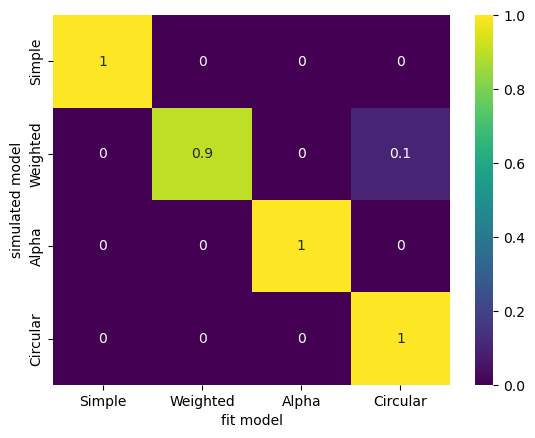

In [95]:
confusion_matrix
for i in range(4):
    confusion_matrix.iloc[i,:] = confusion_matrix.iloc[i,:]/sum(confusion_matrix.iloc[i,:])

sns.heatmap(confusion_matrix,annot=True,cmap='viridis')
plt.xlabel('fit model')
plt.ylabel('simulated model')

In [96]:
confusion_matrix

,Simple,Weighted,Alpha,Circular
Simple,1.0,0.0,0.0,0.0
Weighted,0.0,0.9,0.0,0.1
Alpha,0.0,0.0,1.0,0.0
Circular,0.0,0.0,0.0,1.0
